#Importing

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download jessicali9530/celeba-dataset
! unzip /content/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

#Directory

In [ ]:
import os
import random
import shutil

dataset_dir = '/content/img_align_celeba/img_align_celeba'
output_dir = '/content/selected1_images/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_images = os.listdir(dataset_dir)

num_images_to_select = 10000

# Randomly select images
selected_images = random.sample(all_images, num_images_to_select)

for image_name in selected_images:
    image_path = os.path.join(dataset_dir, image_name)
    shutil.copy(image_path, output_dir)

print("Selected", len(selected_images), "images and saved them to", output_dir)


Selected 10000 images and saved them to /content/selected1_images/


In [ ]:
from PIL import Image
import os

input_dir = '/content/selected1_images/'

output_dir = '/content/resized_images/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

target_size = (64, 64)

for image_name in os.listdir(input_dir):
    image_path = os.path.join(input_dir, image_name)
    img = Image.open(image_path)

    resized_img = img.resize(target_size, Image.ANTIALIAS)

    output_path = os.path.join(output_dir, image_name)
    resized_img.save(output_path)

print("Resized all images to", target_size, "and saved them to", output_dir)


<ipython-input-5-114b3649ea66>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Resized all images to (64, 64) and saved them to /content/resized_images/


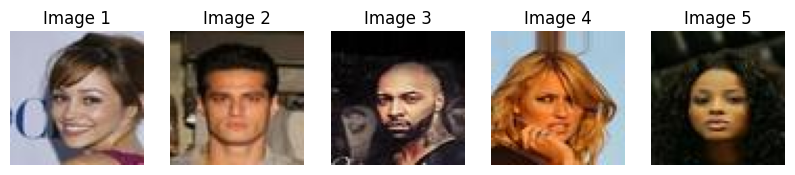

In [ ]:
import matplotlib.pyplot as plt
import os

resized_dir = '/content/resized_images/'

image_files = os.listdir(resized_dir)

selected_images = image_files[:5]

plt.figure(figsize=(10, 5))
for i, image_name in enumerate(selected_images, 1):
    img_path = os.path.join(resized_dir, image_name)
    img = plt.imread(img_path)

    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis('off')

plt.show()


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

data_dir = '/content/resized_images/'

transform = transforms.Compose([
    transforms.ToTensor(),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

dataset = CustomDataset(data_dir, transform=transform)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Test the data loader
for batch in data_loader:
    print("Batch shape:", batch.shape)
    break


Batch shape: torch.Size([32, 3, 64, 64])


#DC GAN

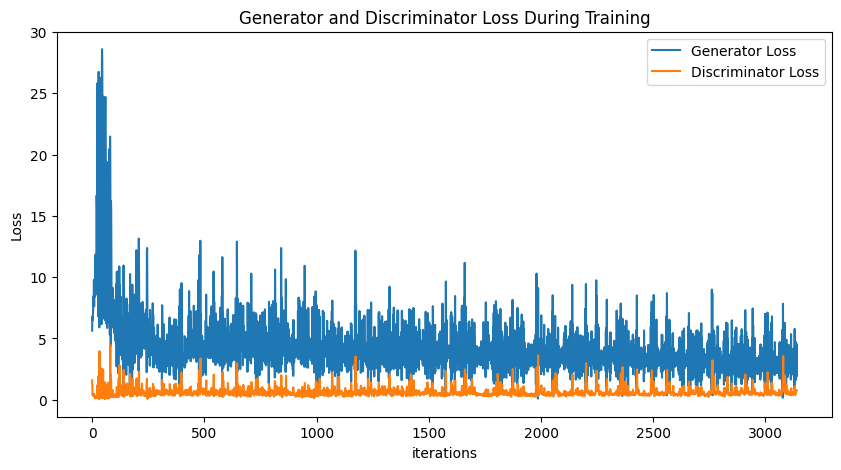

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)  # Output layer for D

    def forward(self, x):
        x = nn.LeakyReLU(0.2)(self.conv1(x))
        x = nn.LeakyReLU(0.2)(self.batchnorm1(self.conv2(x)))
        x = nn.LeakyReLU(0.2)(self.batchnorm2(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 256)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 2*2*448)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(448)
        self.upconv1 = nn.ConvTranspose2d(in_channels=448, out_channels=256, kernel_size=4, stride=2, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 448, 2, 2)
        x = self.relu(self.batchnorm1(x))
        x = self.relu(self.batchnorm2(self.upconv1(x)))
        x = self.relu(self.upconv2(x))
        x = self.relu(self.upconv3(x))
        x = self.tanh(self.upconv4(x))
        return x

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.9, 0.999))

# Loss function
criterion = nn.BCEWithLogitsLoss()
# Training loop
num_epochs = 25

# Lists to store losses
D_losses = []
G_losses = []
for epoch in range(num_epochs):
    for data in enumerate(data_loader):

        real_images = data[1]
        batch_size = real_images.size(0)
        label_real = torch.full((batch_size,), 1.0)  # Real label
        label_fake = torch.full((batch_size,), 0.0)  # Fake label

        # Train Discriminator
        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real.squeeze(1), label_real)

        noise = torch.randn(batch_size, 128)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake.squeeze(1), label_fake)

        loss_D = loss_real + loss_fake
        loss_D.backward(retain_graph=True)
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_gen = discriminator(fake_images)
        label_real_gen = torch.full((batch_size, 1), 1.0)  # Real label for generator loss
        loss_G = criterion(output_gen, label_real_gen)
        loss_G.backward(retain_graph=True)
        optimizer_G.step()

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

        if i % 10 == 0:
            print( f'D_Loss: {loss_D.item():.4f}, G_Loss: {loss_G.item():.4f}')

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()


After 5 epochs

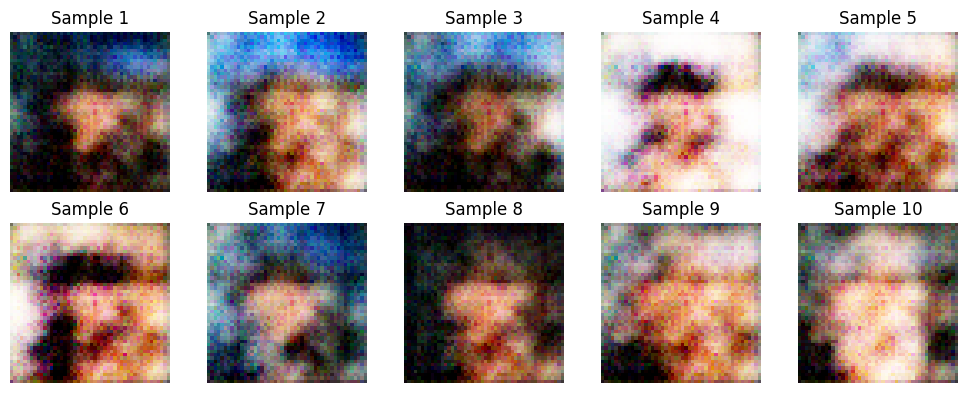

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    noise = torch.randn(10, 128)
    generated_images = generator(noise).cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


After 15 epochs

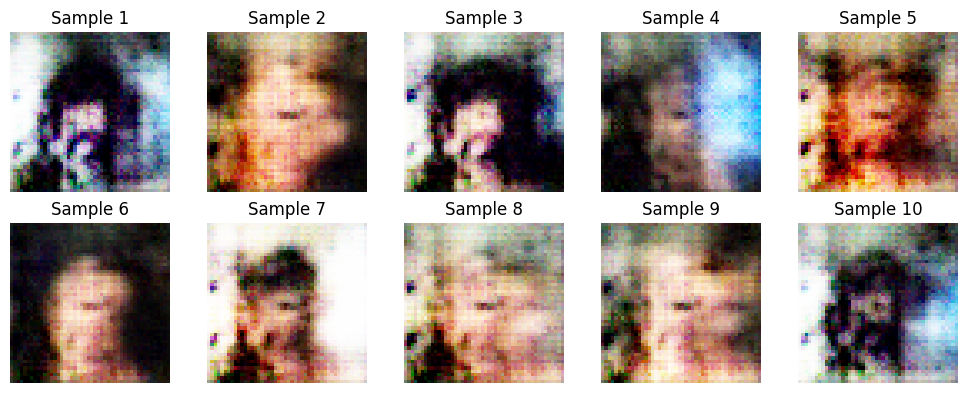

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    noise = torch.randn(10, 128)
    generated_images = generator(noise).cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


After 25 epochs

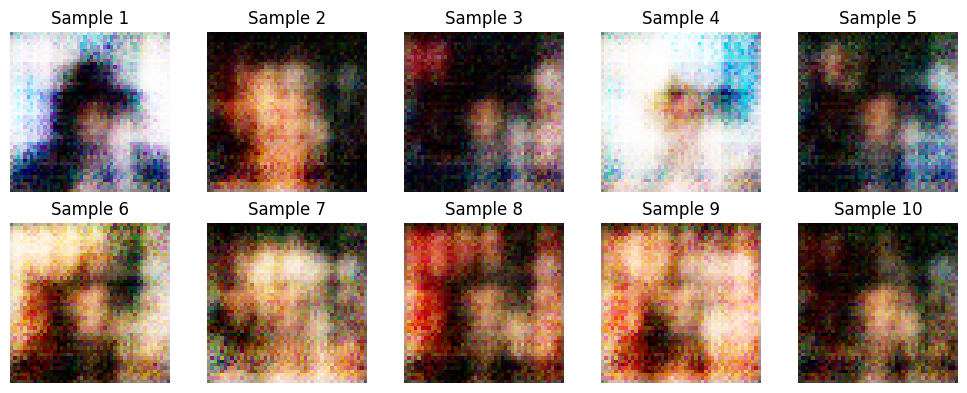

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    noise = torch.randn(10, 128)
    generated_images = generator(noise).cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


#Using LSGAN

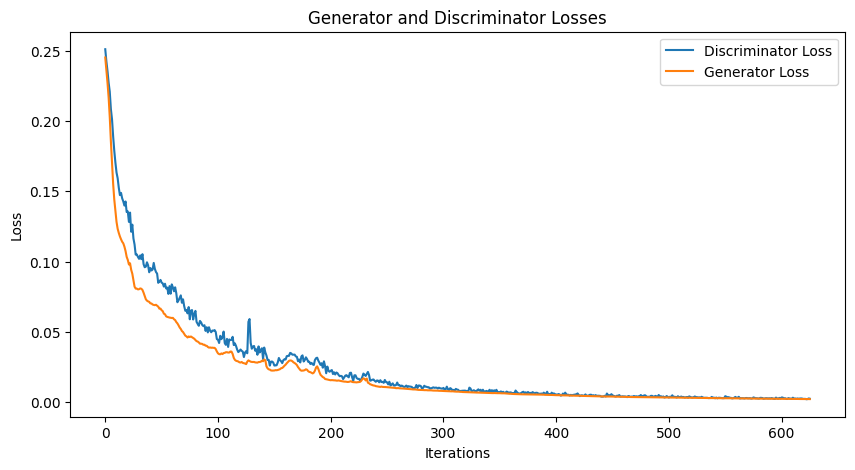

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)  # Output layer for D

    def forward(self, x):
        x = nn.LeakyReLU(0.2)(self.conv1(x))
        x = nn.LeakyReLU(0.2)(self.batchnorm1(self.conv2(x)))
        x = nn.LeakyReLU(0.2)(self.batchnorm2(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 2*2*448)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(448)
        self.upconv1 = nn.ConvTranspose2d(in_channels=448, out_channels=256, kernel_size=4, stride=2, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 448, 2, 2)
        x = self.relu(self.batchnorm1(x))
        x = self.relu(self.batchnorm2(self.upconv1(x)))
        x = self.relu(self.upconv2(x))
        x = self.relu(self.upconv3(x))
        x = self.tanh(self.upconv4(x))
        return x

generator = Generator()
discriminator = Discriminator()

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Least Squares Loss function
criterion = nn.MSELoss()
# Training loop
num_epochs = 25
c = 0.0

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for data in enumerate(data_loader):

        real_images = data[1]
        batch_size = real_images.size(0)
        label_real = torch.full((batch_size,), 1.0)  # Real label
        label_fake = torch.full((batch_size,), 0.0)  # Fake label
        label_fake_gen = torch.full((batch_size,), c)  # Fake label for generator loss

        # Train Discriminator
        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real.squeeze(1), label_real)

        noise = torch.randn(batch_size, 128)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake.squeeze(1), label_fake)

        loss_D = (loss_real + loss_fake) / 2  # Average the loss
        loss_D.backward(retain_graph = True)
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_gen = discriminator(fake_images)
        loss_G = criterion(output_gen.squeeze(1), label_fake_gen)  # Generator wants the discriminator to classify fake images as real
        loss_G.backward(retain_graph=True)
        optimizer_G.step()

        # Store losses
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

        # Print progress
        if i % 100 == 0:
            print( f'D_Loss: {loss_D.item():.4f}, G_Loss: {loss_G.item():.4f}')

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(D_losses, label='Discriminator Loss')
plt.plot(G_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()


After 10 epochs

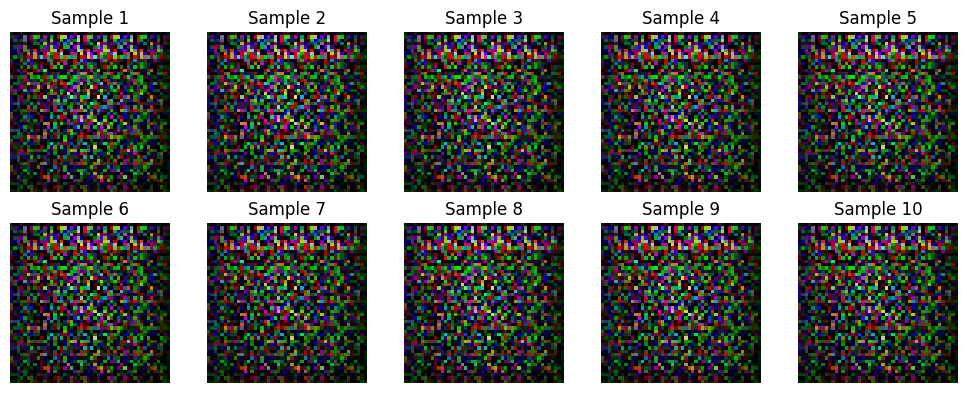

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    noise = torch.randn(10, 128)
    generated_images = generator(noise).cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


After 20 epochs

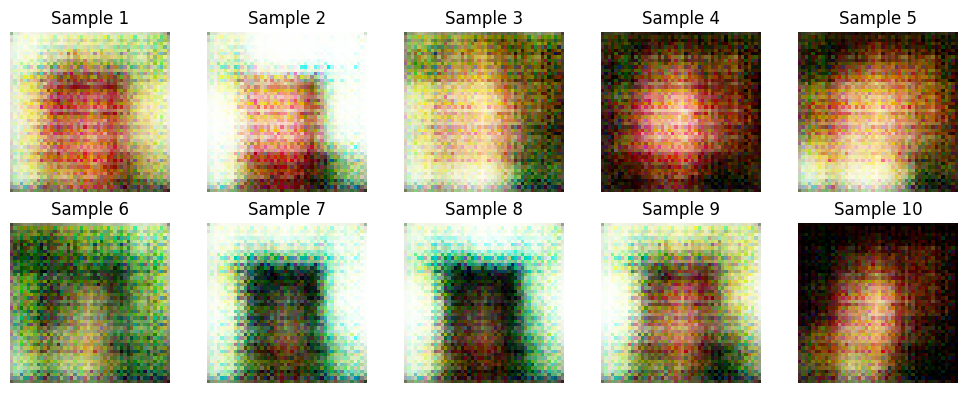

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    noise = torch.randn(10, 128)
    generated_images = generator(noise).cpu()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


#FID Scores

In [18]:
!pip install clean_fid

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.8 MB/s eta 0:00:00


In [19]:
from PIL import Image
import os
import os
import random
import shutil

dataset_dir = '/content/img_align_celeba/img_align_celeba'
output_dir = '/content/selected1_images/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_images = os.listdir(dataset_dir)

num_images_to_select = 100

selected_images = random.sample(all_images, num_images_to_select)

for image_name in selected_images:
    image_path = os.path.join(dataset_dir, image_name)
    shutil.copy(image_path, output_dir)

print("Selected", len(selected_images), "images and saved them to", output_dir)

# Path to the directory containing the selected images
input_dir = '/content/selected1_images/'

# Path to the directory where you want to save the resized images
output_dir = '/content/generate_images/'

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the target size
target_size = (64, 64)

for image_name in os.listdir(input_dir):
    # Open the image
    image_path = os.path.join(input_dir, image_name)
    img = Image.open(image_path)

    resized_img = img.resize(target_size, Image.ANTIALIAS)

    output_path = os.path.join(output_dir, image_name)
    resized_img.save(output_path)

print("Resized all images to", target_size, "and saved them to", output_dir)


Selected 100 images and saved them to /content/selected1_images/


<ipython-input-19-7897b1376f22>:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Resized all images to (64, 64) and saved them to /content/generate_images/


for DC GAN

In [20]:
def generate_images(generator, num_images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        for i in range(num_images):
            noise = torch.randn(1, 128)
            generated_image = generator(noise).cpu().squeeze(0)
            plt.imshow(generated_image.permute(1, 2, 0))
            plt.axis('off')
            plt.savefig(os.path.join(save_dir, f'generated_image_{i}.png'))
            plt.close()

# Generate images
num_generated_images = 100
generated_images1_dir = 'generated1_images'
generate_images(generator, num_generated_images, generated_images1_dir)


for LS GAN

In [21]:
def generate_images(generator, num_images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    with torch.no_grad():
        for i in range(num_images):
            noise = torch.randn(1, 128)
            generated_image = generator(noise).cpu().squeeze(0)
            plt.imshow(generated_image.permute(1, 2, 0))
            plt.axis('off')
            plt.savefig(os.path.join(save_dir, f'generated_image_{i}.png'))
            plt.close()

# Generate images
num_generated_images = 100  # Change as needed
generated_images2_dir = 'generated2_images'
generate_images(generator, num_generated_images, generated_images2_dir)


In [25]:
from cleanfid import fid
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Compute FID score
real_images_dir = '/content/generate_images/'
fid_score = fid.compute_fid(real_images_dir, generated_images1_dir)
print("FID Score:", fid_score)
fid_score = fid.compute_fid(real_images_dir, generated_images2_dir)
print("FID Score(LS GAN):", fid_score)


FID Score: 93.7965
FID Score(LS GAN): 322.7634
